## Links and References

### Shapley



*   [Documentation](https://shap.readthedocs.io/en/latest/index.html) - Reference code for many of the following examples
*   [History & Deep Math](https://en.wikipedia.org/wiki/Shapley_value)
*   [Calculating SHAP Values in ML](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30)
*   [SHAP as a Model Explainer](https://towardsdatascience.com/the-ultimate-guide-using-game-theory-to-interpret-machine-learning-c384cbb6929) - Highly Recommended Read


### Dalex


*   [Python Examples](https://dalex.drwhy.ai/python/)
*   [R Workbook](https://uc-r.github.io/dalex)


## Review: 
Explaining a simple ML Model without Shapley/Dalex/ETC

If you are running this outside of colab, this section may throw errors when working with graphviz, it's not needed for any of the Shapley codes so you can safely comment/delete it out if needed.

In [141]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import sklearn as sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
bank = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')
ro = RandomOverSampler()


X = pd.DataFrame()
features = ['job','housing','poutcome', 'education'] #'job','marital','education', 'default', 'housing','contact','poutcome'
X = pd.get_dummies(bank[features], drop_first=True)
X= X.drop(columns=['education_illiterate', 'job_self-employed', 'job_unemployed'])
X['age'] = bank['age']
X['campaign'] = bank['campaign']
X['euribor3m'] = bank['euribor3m']
y = bank['y']

X_new, y_new = ro.fit_resample(X, y)
# Split our data into training and test data, with 30% reserved for testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=92)

In [142]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=15, max_depth=6)
# Train
model.fit(X_train, y_train)
# Extract single tree
estimator = model.estimators_[5]

In [143]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = list(X.columns),
                class_names = list(y.unique()),
                rounded = True, proportion = True, 
                precision = 2, filled = True)

In [144]:
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

Tree with Feature impacts.

In [145]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Feature Importance:

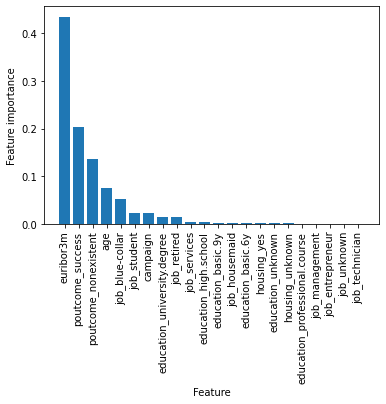

In [146]:
import matplotlib.pyplot as plt
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Sort the features by importance
sorted_features = X.columns[indices]

# Plot the feature importance scores
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), sorted_features, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.show()

## Intro to Shap Values 

---

#### What is SHAP?
SHAP (**SH**apley **A**dditive ex**P**lanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.


For simplicities sake, here is an example of how shap values can be employed to explain linear regression models

This dataset consists of 20,640 blocks of houses across California in 1990, where our goal is to predict the natural log of the median home price from 8 different features.
[Source](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

In [ ]:
#install/import shap
!pip install shap
import shap as shap

In [ ]:
# a classic housing price dataset
X,y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

Exact explainer: 1001it [00:39, 12.16it/s]                         


In [ ]:
## Example of standard linear regression summary ##
import statsmodels.api as sm

#define response variable
y = y
#define predictor variables
x = X
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     280.9
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          1.13e-248
Time:                        19:31:58   Log-Likelihood:                -971.04
No. Observations:                1000   AIC:                             1960.
Df Residuals:                     991   BIC:                             2004.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.9881      2.676    -12.329      0.0

Shap_values is a 2D array. Each row is a single prediction made by the model. Each column represents a specific feature used in the model. Each SHAP value represents how much (and in which way) a feature contributes to the output of a given row’s prediction.

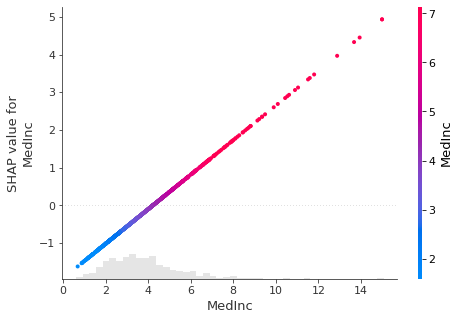

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


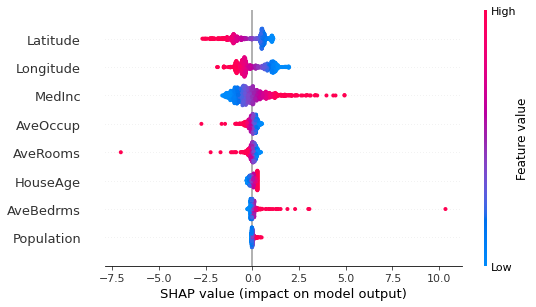

In [ ]:
shap.plots.scatter(shap_values[:,"MedInc"],color=shap_values[:,"MedInc"])
shap.plots.beeswarm(shap_values)

### Jumping into the black box
Same data but with an xgboost model

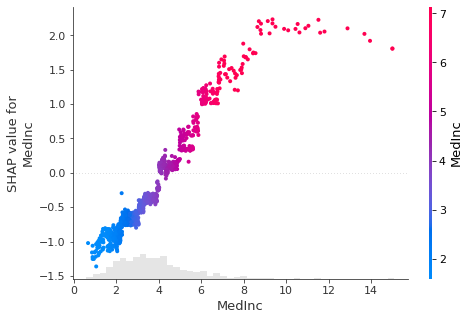

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


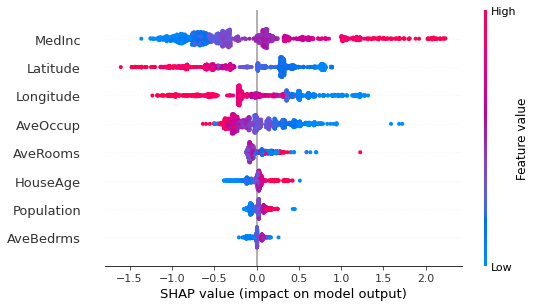

In [ ]:

# train XGBoost model
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)


shap.plots.scatter(shap_values_xgb[:,"MedInc"],color=shap_values[:,"MedInc"])
shap.plots.beeswarm(shap_values_xgb)

## Decision Trees with Shapley


---




In [ ]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
import lightgbm as lgb
# create a train/test split
random_state = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.277144


In [ ]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value

import warnings
select = range(20)
features = X_test.iloc[select]
features_display = X_display.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Force Plots:

Feature Importance as direction of affect for an individual prediction.

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

Decision Plots:

**Decision plot Uses:**
 1. Show a large number of feature effects clearly. 
 2. Visualize multioutput predictions. 
 3. Display the cumulative effect of interactions. 
 4. Explore feature effects for a range of feature values. 
 5. Identify outliers. 
 6. Identify typical prediction paths. 
 7. Compare and contrast predictions for several models.

[Source](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html#SHAP-Decision-Plots)

"Refer to the decision plot of the 20 test observations below. Note: This plot isn’t informative by itself; we use it only to illustrate the primary concepts. * The x-axis represents the model’s output. In this case, the units are log odds. * The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model’s expected value like a linear model’s effects are relative to the intercept. * The y-axis lists the model’s features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. This is usually different than the importance ordering for the entire dataset. In addition to feature importance ordering, the decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering. * Each observation’s prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation’s predicted value. This value determines the color of the line on a spectrum. * Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model’s base value. This shows how each feature contributes to the overall prediction. * At the bottom of the plot, the observations converge at explainer.expected_value."

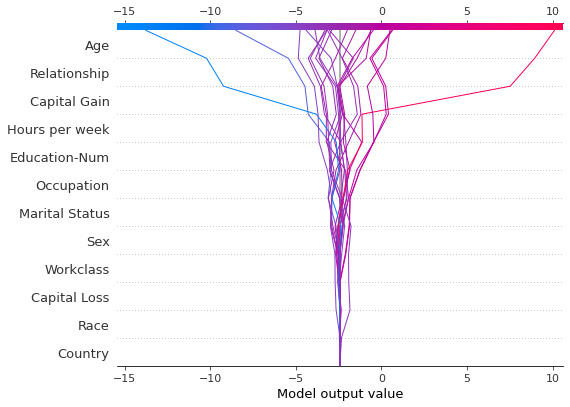

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)

Highlighting misclassification:

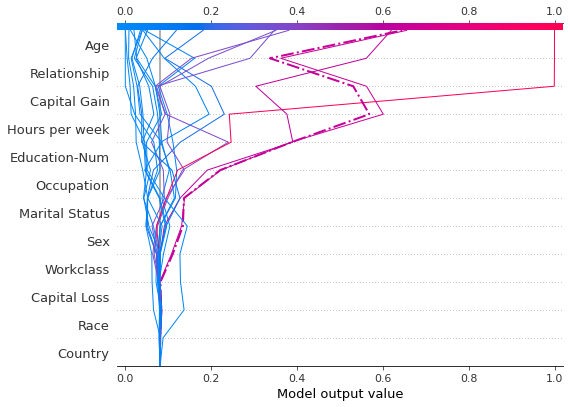

In [ ]:
y_pred = (shap_values.sum(1) + expected_value) > 0
misclassified = y_pred != y_test[select]
shap.decision_plot(expected_value, shap_values, features_display, link='logit', highlight=misclassified)

#### Looking at many predictions
First 1 prediction of many, then many of many

In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Lambda
from keras.models import Model
from keras.layers import Embedding
from tqdm import tqdm

X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k,dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
# build model

input_els = []
encoded_els = []
for k,dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

# train model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss='binary_crossentropy')
regression.fit(
    [X_train[k].values for k,t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k,t in dtypes], y_valid)
)

Similar to the SHAP force plot from above, but now an average of each features general effects across a sample of predictions.

In [ ]:
shap.initjs()
def f(X):
    return regression.predict([X[:,i] for i in range(X.shape[1])]).flatten()
explainer = shap.KernelExplainer(f, X.iloc[:50,:])
shap_values = explainer.shap_values(X.iloc[299,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299,:])

782/782 [==============================] - 4s 5ms/step


In [ ]:
#This one takes a few minutes
shap_values50 = explainer.shap_values(X.iloc[280:330,:], nsamples=500)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values50, X_display.iloc[280:330,:])

## Images

---

Shapley in Convolutional Networks for image recognition

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 3it [05:54, 177.07s/it]


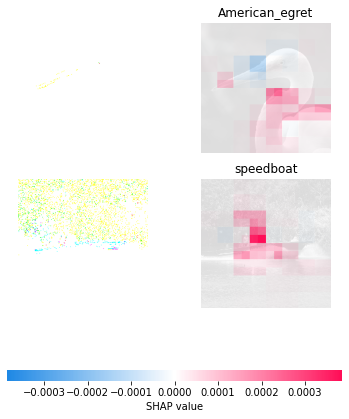

In [ ]:
#Also takes a good couple minutes to run
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import json
import shap
import tensorflow as tf

# load pre-trained model and choose two images to explain
model = ResNet50(weights='imagenet')
def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)
X, y = shap.datasets.imagenet50()

# load the ImageNet class names as a vectorized mapping function from ids to names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

Something funny is happening with the above output, reference below for the documention version of the output.

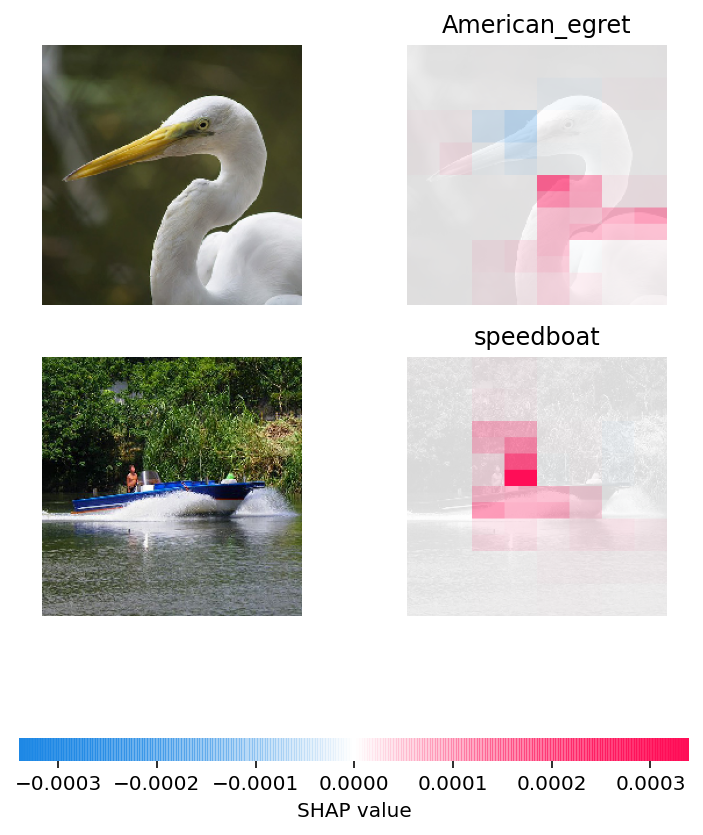